# DNN回归预测(多要素)(完成)

In [19]:

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [20]:
Config = {
    'data_path': r'C:\Users\lzwDT\PycharmProjects\corona_days\afterCoronaHospital.csv',
    'feature_num':12,
    'target' :'day_divided 3',
    'csv_path' : 'submission.csv',
    'k_flod': 5,
}


# 数据处理

In [21]:
train = pd.read_csv(Config['data_path'])

# redefine the type error of the 'to_csv'(mainly about int to obeject)
col_dict = {'init_volume_sum':float,
            'is_Emphysema':str,
            'is_Atelectasis':str,
            'degreeOfAlveolarConsolidation':str,
            'is_fibrotic_lesions':str,
            'is_noduleMass':str,
            'is_hollowCavity':str,
            'is_calcification':str,
            'is_pleuralEffusion':str,
            'is_pleuralThickeningAdhesiveCalcification':str,
            'degreeOfBoneHyperplasia':str}
convert_column_name = list(col_dict.keys())
convert_column_name.pop(0)
train[convert_column_name] = train[convert_column_name].astype('int32').astype('object')
print(f'datasets name is \'train\'')

datasets name is 'train'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 51 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   init_volume_sum                            489 non-null    float64
 1   init_volume_sum_per                        489 non-null    float64
 2   init_avg_volume                            489 non-null    float64
 3   final_volume_sum                           489 non-null    float64
 4   final_volume_sum_per                       489 non-null    float64
 5   final_avg_volume                           489 non-null    float64
 6   is_Emphysema                               489 non-null    object 
 7   is_Atelectasis                             489 non-null    object 
 8   degreeOfAlveolarConsolidation              489 non-null    object 
 9   is_fibrotic_lesions                        489 non-null    object 
 10  i

In [22]:
# 剔除小于10天和大于50天的数据
train = train[train.day_hospitalized < 50]
train = train[train.day_hospitalized > 10]

train = train.reset_index()
del train['index']

# 将数据集分为三天一单位
train[Config['target']] = 42
for x in range(train.shape[0]):
    train[Config['target']][x] = train['day_hospitalized'][x] / 3

# 数据集可视化
#Analysis the data distribution about label 'divided 3'
# train_visual = train
# train_result = train_visual.groupby('day_divided 3').size()
# plt.bar(list(train_result.index),train_result)
# plt.xlabel('Days')
# plt.ylabel('number')
# plt.title('trainData  \'3 divided\'  ')
# plt.show()

c:\Users\lzwDT\anaconda3\envs\bilitorch\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [23]:
from sklearn.model_selection import train_test_split

train_data,test_data = train_test_split(train,test_size=0.1)

train_data = train_data.reset_index()

test_data = test_data.reset_index()

print(train_data.shape,test_data.shape)

(408, 53) (46, 53)


In [24]:
print(train_data.shape)
print(test_data.shape)

(408, 53)
(46, 53)


In [25]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   index  init_volume_sum  init_volume_sum_per  init_avg_volume  \
0    210            38.79                 0.75           -680.0   
1    202             3.83                 0.15           -530.0   
2    250             1.53                 0.03           -709.0   
3    254           466.54                14.58           -391.0   

   averageLiverFat  day_hospitalized  day_divided 3  
0             13.9                43             14  
1             12.1                23              7  
2              6.9                24              8  
3             15.8                34             11  


## 特征选择

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


features = pd.read_csv(Config['data_path'])

# features.info()
# print(features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
x_data, y_data = train.iloc[:,:-2],train.iloc[:,-1]

#try choose your k best features
k = Config['feature_num']
selector = SelectKBest(score_func=f_regression, k=k)
result = selector.fit(x_data, y_data)

#result.scores_ inclues scores for each features
#np.argsort sort scores in ascending order by index, we reverse it to make it descending.
idx = np.argsort(result.scores_)[::-1]
# print(f'Top {k} Best feature score ')
# print(result.scores_[idx[:k]])

print(f'\nTop {k} Best feature index ')
print(idx[:k])

print(f'\nTop {k} Best feature name')
print(x_data.columns[idx[:k]])

selected_idx = list(np.sort(idx[:k]))
# print(list(x_data.columns[selected_idx]))

feature_list = list(x_data.columns[selected_idx])




Top 12 Best feature index 
[23 46 28  1 13  8  0 24 27  4 10 45]

Top 12 Best feature name
Index(['cardiothoracic_ratio', 'degreeOfBoneHyperplasia',
       'AbdominalShortDiameterOfTheSameLayer', 'init_volume_sum_per',
       'is_pleuralEffusion', 'degreeOfAlveolarConsolidation',
       'init_volume_sum', 'mainPulmonaryArtery',
       'inferiorVenaCavaShortDiameter', 'final_volume_sum_per',
       'is_noduleMass', 'T12_BMD'],
      dtype='object')


In [27]:
all_features = pd.concat((train_data.iloc[:, selected_idx], test_data.iloc[:, selected_idx]))

all_features = all_features.iloc[:,1:]
# all_features

## 标准化

In [28]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

## 独热化

In [29]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(454, 17)

In [30]:
# 将数据转为torch
n_train = train_data.shape[0]

# 获取shap变量
origin_shap_test_features = all_features[n_train:]
shap_train_features = all_features[:n_train].to_numpy()
shap_test_features = all_features[n_train:].to_numpy()

# 变量转为tensor
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data[Config['target']].values.reshape(-1, 1), dtype=torch.float32)

# 网络搭建

## 网络结构及LOSS function

In [31]:
# 定义function
loss = nn.MSELoss()
in_features = train_features.shape[1]

# 定义网络结构
def get_net():
    net = nn.Sequential(nn.Linear(in_features,32),
                        nn.LeakyReLU(0.2),
                        nn.BatchNorm1d(32),
                        nn.Dropout(0.2),
                        
                        nn.Linear(32, 16),
                        nn.LeakyReLU(0.2),
                        # nn.BatchNorm1d(16),
                        nn.Dropout(0.1),
                        nn.Linear(16, 1)
                        )
    return net

In [32]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    # rmse = torch.sqrt(loss(torch.log(clipped_preds),
    #                        torch.log(labels)))
    
    # MSE :
    rmse = loss(net(features),labels)
    return rmse.item()

## Adam 优化器

In [33]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# $K$折交叉验证

In [34]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

当我们在$K$折交叉验证中训练$K$次后，[**返回训练和验证误差的平均值**]。


In [35]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='mse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练mse{float(train_ls[-1]):f}, '
              f'验证mse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 训练


折1，训练mse7.716654, 验证mse13.445801
折2，训练mse8.592120, 验证mse11.550109
折3，训练mse8.348578, 验证mse10.226314
折4，训练mse8.015744, 验证mse11.948996
折5，训练mse8.813235, 验证mse8.986711
5-折验证: 平均训练log mse: 8.297266, 平均验证log mse: 11.231586


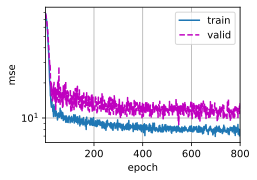

In [36]:
k, num_epochs, lr, weight_decay, batch_size = 5, 800, 2e-3, 1e-5, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log mse: {float(train_l):f}, '
      f'平均验证log mse: {float(valid_l):f}')

# 预测

In [37]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log mse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log mse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()

    # print(pd.Series(preds.reshape(1, -1)[0]))
    test_data['origin day_divided 3'] = test_data[Config['target']]
    test_data[Config['target']] = pd.Series(preds.reshape(1, -1)[0])
    # print(test_data[Config['target']])
    # reValidLoss = loss(test_data['origin day_divided 3'],test_data[Config['target']])
    # print(f'reValidLoss MSE :{reValidLoss}')
    submission = pd.concat([test_data['origin day_divided 3'], test_data[Config['target']]], axis=1)
    submission.to_csv(Config['csv_path'], index=False)
    return net

下面的代码将生成一个名为`submission.csv`的文件。

训练log mse：7.957262


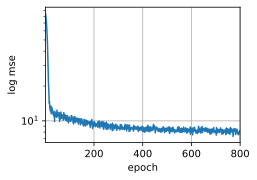

In [38]:
model = train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

The MSE Loss of test: 11.852460861206055


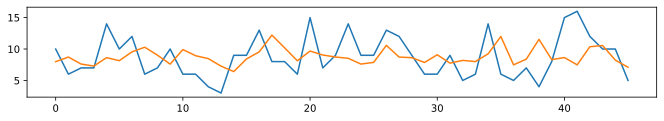

In [39]:

verifyData = pd.read_csv(Config['csv_path'])
# verifyData.iloc[:,0].tolist()
# a = verifyData.iloc[:,0].tolist()
origin = torch.FloatTensor(verifyData.iloc[:,0].tolist())
predict = torch.FloatTensor(verifyData.iloc[:,1].tolist())
print(f'The MSE Loss of test: {loss(origin,predict)}')

import matplotlib.pyplot as plt
plt.axes([0, 0, 2.5, 0.5])
plt.plot(origin)
plt.plot(predict)

plt.show()

In [40]:
import pandas as pd 
result1 = pd.read_csv(Config['csv_path'])
# result1['day_divided 3']

mix up
timm
对比学习


# SHAP 可解释性分析

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


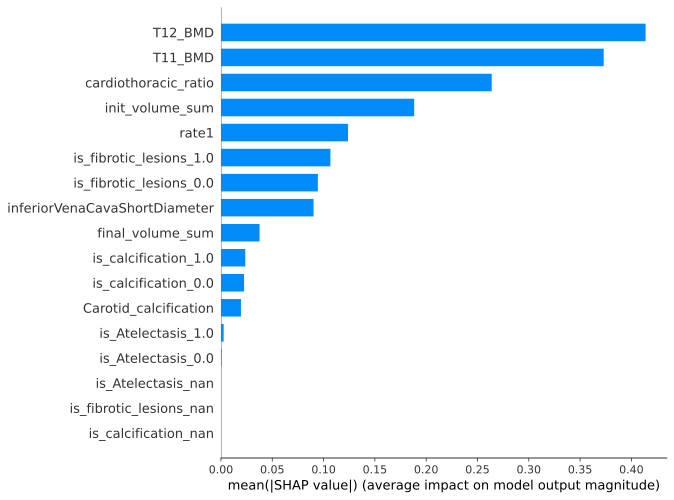

In [41]:
# import shap

# explainer = shap.DeepExplainer(model, shap_train_features)
# shap_values = explainer.shap_values(shap_test_features)
# shap.summary_plot(shap_values, shap_test_features, plot_type='bar')


import shap

explainer = shap.DeepExplainer(model, torch.from_numpy(shap_train_features).float())
shap_values = explainer.shap_values(torch.from_numpy(shap_test_features).float())
shap.summary_plot(shap_values, origin_shap_test_features, plot_type='bar')

## 小结

* 真实数据通常混合了不同的数据类型，需要进行预处理。
* 常用的预处理方法：将实值数据重新缩放为零均值和单位方法；用均值替换缺失值。
* 将类别特征转化为指标特征，可以使我们把这个特征当作一个独热向量来对待。
* 我们可以使用$K$折交叉验证来选择模型并调整超参数。
* 对数对于相对误差很有用。

## 练习

1. 把你的预测提交给Kaggle，它有多好？
1. 你能通过直接最小化价格的对数来改进你的模型吗？如果你试图预测价格的对数而不是价格，会发生什么？
1. 用平均值替换缺失值总是好主意吗？提示：你能构造一个不随机丢失值的情况吗？
1. 通过$K$折交叉验证调整超参数，从而提高Kaggle的得分。
1. 通过改进模型（例如，层、权重衰减和dropout）来提高分数。
1. 如果我们没有像本节所做的那样标准化连续的数值特征，会发生什么？


[Discussions](https://discuss.d2l.ai/t/1824)
